#  MULTICLASS CLASSIFICATION PART

In [1]:
#Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from scipy.stats import randint as sp_randint
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score,recall_score ,f1_score,roc_curve, auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE


# to display all column of datapoints
pd.set_option('display.max_columns', None)



# ii) Multiclass Classification Problem

In [2]:
""" Reload the cleaned datasets """

df_train=pd.read_csv("cleaned_train.csv")

df_test=pd.read_csv("cleaned_test.csv")

In [3]:
""" In the below code we have basically divided the intrusions based on the intrusion types,
and creating a new column class_label_mul with the help of this data based on both the train and the test data frame """

"""
Normal=0
Probing=1
DOS=2
U2R=3
R2L=4

"""


mapping = {'ipsweep.': 1,'satan.': 1,'nmap.': 1,'portsweep.': 1,'saint.': 1,'mscan.': 1,
        'teardrop.': 2,'pod.': 2,'land.': 2,'back.': 2,'neptune.': 2,'smurf.': 2,'mailbomb.': 2,
        'udpstorm.': 2,'apache2.': 2,'processtable.': 2,
        'perl.': 3,'loadmodule.': 3,'rootkit.': 3,'buffer_overflow.': 3,'xterm.': 3,'ps.': 3,
        'sqlattack.': 3,'httptunnel.': 3,
        'ftp_write.': 4,'phf.': 4,'guess_passwd.': 4,'warezmaster.': 4,'warezclient.': 4,'imap.': 4,
        'spy.': 4,'multihop.': 4,'named.': 4,'snmpguess.': 4,'worm.': 4,'snmpgetattack.': 4,
        'xsnoop.': 4,'xlock.': 4,'sendmail.': 4,
        'normal.': 0
        }


In [4]:
df_train['class_label_mul'] = df_train['class_label'].apply(lambda i: mapping[i])
df_test['class_label_mul'] = df_test['class_label'].apply(lambda i: mapping[i])

In [5]:
df_train=df_train.drop(['class_label'], axis = 1)

df_test=df_test.drop(['class_label'], axis = 1)

In [6]:
# Dropping Non intrusion type class label, or class label 0

df_train=df_train[df_train.class_label_mul != 0]

df_test=df_test[df_test.class_label_mul != 0]

In [7]:
df_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class_label_mul
6642,184,tcp,telnet,SF,1511,2957,0,0,0,3,0,1,2,1,0,0,1,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3,1.00,0.00,1.00,0.67,0.0,0.0,0.0,0.0,3
6643,305,tcp,telnet,SF,1735,2766,0,0,0,3,0,1,2,1,0,0,1,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,4,1.00,0.00,0.50,0.50,0.0,0.0,0.0,0.0,3
35231,79,tcp,telnet,SF,281,1301,0,0,0,2,0,1,1,1,0,0,4,2,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,10,1.00,0.00,1.00,0.30,0.0,0.0,0.0,0.1,3
35863,25,tcp,telnet,SF,269,2333,0,0,0,0,0,1,0,1,0,2,2,1,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69,2,0.03,0.06,0.01,0.00,0.0,0.0,0.0,0.0,3
66757,0,tcp,telnet,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.5,1.0,0.0,0.0,0.5,1.0,0.0,1,2,1.00,0.00,1.00,1.00,1.0,0.5,0.0,0.0,2


In [8]:
df_test.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class_label_mul
276,707,tcp,domain,SF,1562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,1,0.00,0.02,0.00,0.0,0.0,0.0,0.0,0.0,4
277,703,tcp,X11,SF,57164,35576,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.00,0.00,1.00,0.0,0.0,0.0,0.0,0.0,4
378,199,tcp,X11,SF,56124,17588,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,1,0.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,4
396,0,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.00,0.01,0.01,0.0,0.0,0.0,0.0,0.0,4
401,433,tcp,X11,SF,31645608,207796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,2,0.01,0.02,0.00,0.0,0.0,0.0,0.0,0.0,4


In [9]:
df_train.shape , df_test.shape

((172053, 42), (19211, 42))

# Features Engineering and Modeling

## Part 1 (Without Over Sampling or Under Sampling the Data)

### Label Encoding catagorical or discrete features


In [10]:

def label_encoding(X_train,X_test,feature):
    
    #LabelEncoder() function Encode target labels with value between 0 and n_classes-1
    le = LabelEncoder()
    
    data1= le.fit_transform(X_train[feature].values)
    
    data2= le.fit_transform(X_test[feature].values)
    
    return data1,data2
    


In [11]:
# protocol
X_train_protocol_type , X_test_protocol_type = label_encoding(df_train,df_test,'protocol_type')

#service
X_train_service , X_test_service = label_encoding(df_train,df_test,'service')

#flag
X_train_flag , X_test_flag = label_encoding(df_train,df_test,'flag')

In [12]:
#taking all the continuous features name in a list

continuous_features=["duration","src_bytes",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins","num_compromised","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]



In [13]:
#Storing all the continuous features in the x_train and x_test

X_train = df_train[continuous_features]

X_test = df_test[continuous_features]


In [14]:
#storing encoded values into x_train and x_test

X_train['protocol_type'] = X_train_protocol_type
X_train['service'] = X_train_service
X_train['flag'] = X_train_flag

X_test['protocol_type'] = X_test_protocol_type
X_test['service'] = X_test_service
X_test['flag'] = X_test_flag

In [15]:
#storing class_label value into y_train and y_test

y_train=df_train['class_label_mul']

y_test=df_test['class_label_mul']

In [16]:
X_train.shape , X_test.shape

((172053, 35), (19211, 35))

In [17]:
y_train.shape , y_test.shape

((172053,), (19211,))

In [18]:
from collections import Counter

#check the count of each and every intrusion 
Counter(y_train)

Counter({3: 52, 2: 159775, 4: 936, 1: 11290})

### Modeling

In [11]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    
    # C = 4,4 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    B =(C/C.sum(axis=0))
    
    
    labels = [1,2,3,4]
    cmap=sns.light_palette("green")
    
    #Confusion matrix
    
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #Precision matrix

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    #Recall matrix
    
    
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

# Logistic Regression 

log_loss for c =  1e-05 is 0.9765452676211018
log_loss for c =  0.0001 is 1.045520985184581
log_loss for c =  0.001 is 0.9787799063101821
log_loss for c =  0.01 is 0.9895308910789922
log_loss for c =  0.1 is 0.9724399694342463
log_loss for c =  1 is 0.9681231839214306
log_loss for c =  10 is 0.9640746676358333
log_loss for c =  100 is 0.9766753829765714
log_loss for c =  1000 is 0.9815532353021835


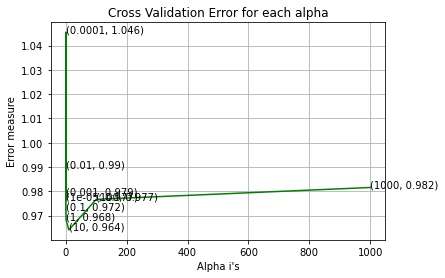

log loss for train data 0.26230674267942095
log loss for test data 0.9640746676358333
Number of misclassified points  25.079381604289207
-------------------------------------------------- Confusion matrix --------------------------------------------------


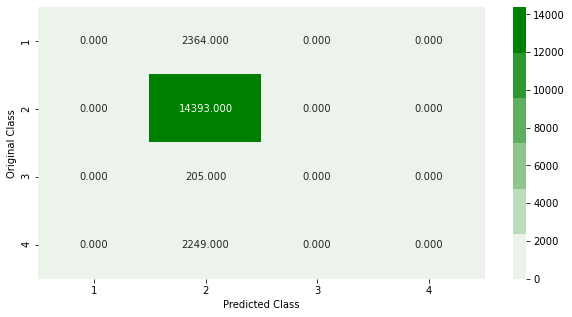

-------------------------------------------------- Precision matrix --------------------------------------------------


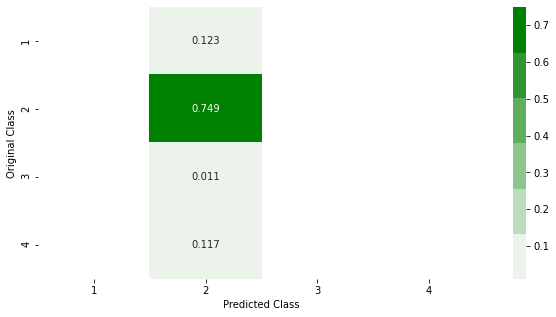

Sum of columns in precision matrix [nan  1. nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


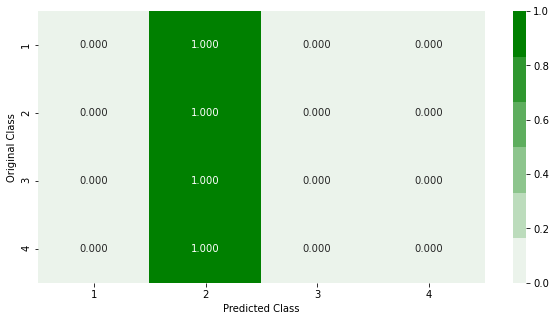

Sum of rows in precision matrix [1. 1. 1. 1.]


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")



#log loss calculation part

alpha = [10 ** x for x in range(-5, 4)]
test_log_error_array=[]


for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))


for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])

best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha

fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part
logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',(log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',(log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [21]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\LogisticRegression_multiclass_without_sampling.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\LogisticRegression_multiclass_without_sampling.joblib']

In [22]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 2


In [23]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 2


# Random Forest

log_loss for c =  10 is 0.44684135624770216
log_loss for c =  50 is 0.4652655549713092
log_loss for c =  100 is 0.4672785954337941
log_loss for c =  500 is 0.46143209859415424
log_loss for c =  1000 is 0.4723424932509887
log_loss for c =  2000 is 0.4720359914550108
log_loss for c =  3000 is 0.4731007640007916


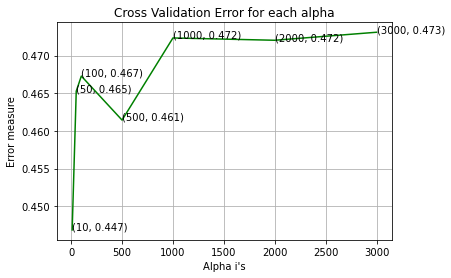

For values of best alpha =  10 The train log loss is: 0.0162395647154516
For values of best alpha =  10 The test log loss is: 0.44684135624770216
Number of misclassified points  13.185154338660144
-------------------------------------------------- Confusion matrix --------------------------------------------------


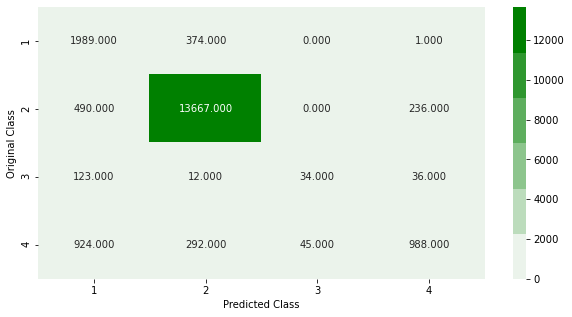

-------------------------------------------------- Precision matrix --------------------------------------------------


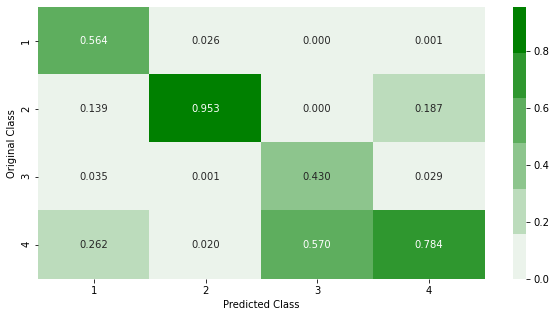

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


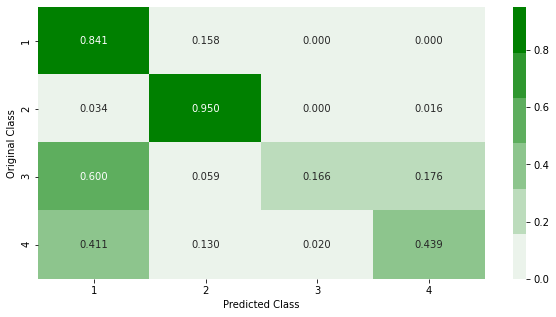

Sum of rows in precision matrix [1. 1. 1. 1.]
Number of misclassified points  13.185154338660144
-------------------------------------------------- Confusion matrix --------------------------------------------------


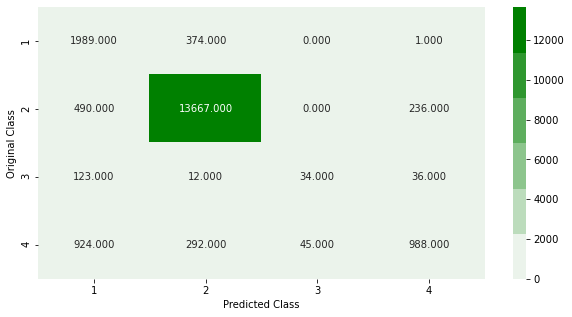

-------------------------------------------------- Precision matrix --------------------------------------------------


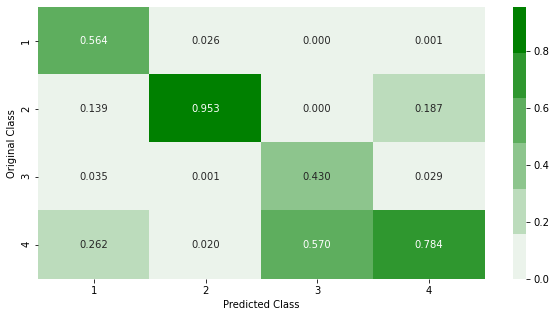

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


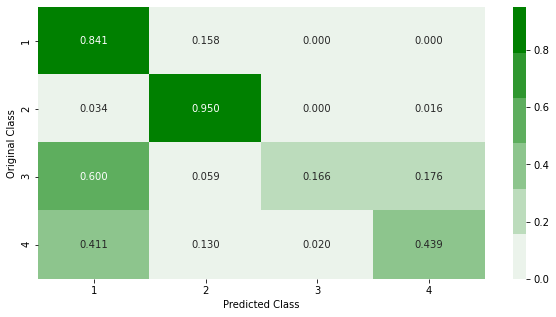

Sum of rows in precision matrix [1. 1. 1. 1.]


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")

#log loss calculation part

alpha=[10,50,100,500,1000,2000,3000]
test_log_error_array=[]

for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])


best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha

fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [25]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\RandomForestClassifier_multiclass_without_sampling.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\RandomForestClassifier_multiclass_without_sampling.joblib']

In [26]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 2


In [27]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 1


# XgBoost Classification

log_loss for c =  10 is 0.4962594224297085
log_loss for c =  50 is 0.4128184816585322
log_loss for c =  100 is 0.4103750171759317
log_loss for c =  500 is 0.4009059771624268
log_loss for c =  1000 is 0.40040941795053697
log_loss for c =  2000 is 0.3990661074560133


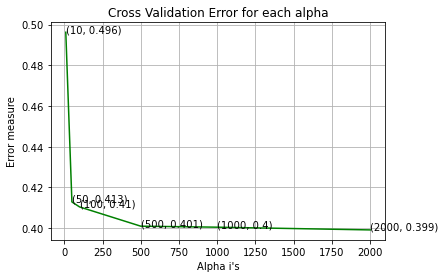

For values of best alpha =  2000 The train log loss is: 0.0206429321936979
For values of best alpha =  2000 The test log loss is: 0.3990661074560133
Number of misclassified points  8.672114934152308
-------------------------------------------------- Confusion matrix --------------------------------------------------


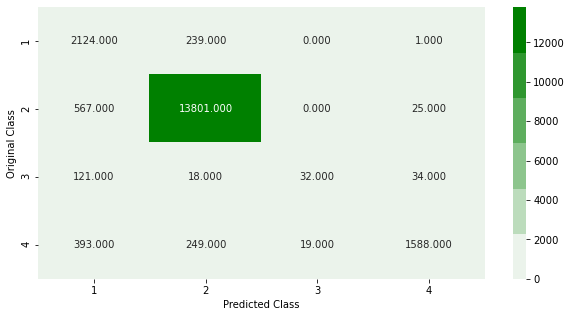

-------------------------------------------------- Precision matrix --------------------------------------------------


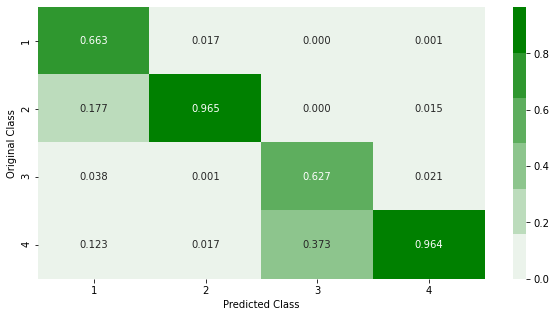

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


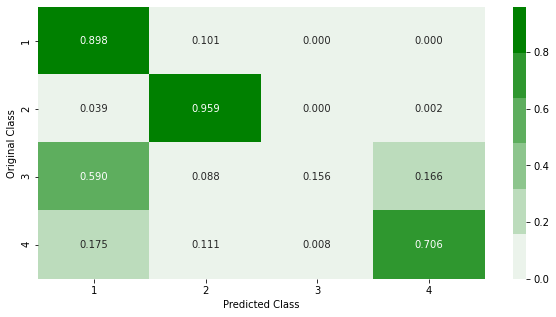

Sum of rows in precision matrix [1. 1. 1. 1.]


In [28]:
import xgboost as xgb

#log loss calculation part

alpha=[10,50,100,500,1000,2000]

test_log_error_array=[]
for i in alpha:
    x_cfl=xgb.XGBClassifier(n_estimators=i,nthread=-1,eval_metric='mlogloss')
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])


best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha

fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part

x_cfl=xgb.XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1,eval_metric='mlogloss')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [29]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\XGBClassifier_multiclass_without_sampling.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\XGBClassifier_multiclass_without_sampling.joblib']

In [30]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 2


In [31]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 1


## Part 2 Under Sampling 

In [12]:
# protocol
X_train_protocol_type , X_test_protocol_type = label_encoding(df_train,df_test,'protocol_type')

#service
X_train_service , X_test_service = label_encoding(df_train,df_test,'service')

#flag
X_train_flag , X_test_flag = label_encoding(df_train,df_test,'flag')

In [13]:
continuous_features=["duration","src_bytes",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins","num_compromised","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]



In [15]:
y = df_train['class_label_mul'] 
x = df_train[continuous_features]

In [16]:
x.shape , y.shape

((172053, 32), (172053,))

In [17]:
x['protocol_type'] = X_train_protocol_type
x['service'] = X_train_service
x['flag'] = X_train_flag


In [18]:
x.shape , y.shape

((172053, 35), (172053,))

In [19]:
from collections import Counter

Counter(y)

Counter({3: 52, 2: 159775, 4: 936, 1: 11290})

In [20]:
from imblearn.under_sampling import NearMiss

nm=NearMiss()

X_train_nm,y_train_nm=nm.fit_resample(x,y)


In [21]:

print("The number of classes before fit {}".format(Counter(y)))

print("The number of classes after fit {}".format(Counter(y_train_nm)))


The number of classes before fit Counter({2: 159775, 1: 11290, 4: 936, 3: 52})
The number of classes after fit Counter({1: 52, 2: 52, 3: 52, 4: 52})


In [22]:
X_train_nm.shape , y_train_nm.shape

((208, 35), (208,))

In [23]:
X_train_nm['class_label_mul'] = y_train_nm

In [24]:
X_train_nm.shape

(208, 36)

In [25]:
X_train_nm.to_csv("under_sample_train_mul.csv", index=False)


In [26]:
""" Reload the cleaned datasets """

df_train2=pd.read_csv("under_sample_train_mul.csv")

In [27]:
df_train2.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,class_label_mul
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.50,1.0,0.0,0.0,0.50,1.0,0.0,8,1,0.12,0.50,0.12,0.0,0.12,1.0,0.0,0.0,1,48,10,1
1,6,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.0,0.0,0.0,1.00,0.0,0.0,6,1,0.17,0.67,0.17,0.0,0.00,0.0,0.0,0.0,1,43,9,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0.67,1.0,0.0,0.0,0.33,1.0,0.0,9,1,0.11,0.56,0.22,0.0,0.22,1.0,0.0,0.0,1,48,10,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0.75,1.0,0.0,0.0,0.25,1.0,0.0,10,1,0.10,0.60,0.30,0.0,0.30,1.0,0.0,0.0,1,48,10,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1.00,1.0,0.0,0.0,0.33,1.0,0.0,11,1,0.09,0.64,0.36,0.0,0.36,1.0,0.0,0.0,1,48,10,1


In [28]:
df_train2.shape

(208, 36)

In [29]:
y_train=df_train2['class_label_mul']

X_train=df_train2.drop(['class_label_mul'], axis = 1)

In [30]:
X_test = df_test[continuous_features]

In [31]:
X_test['protocol_type'] = X_test_protocol_type
X_test['service'] = X_test_service
X_test['flag'] = X_test_flag


In [32]:
y_test=df_test['class_label_mul']

In [33]:
X_test.shape , y_test.shape

((19211, 35), (19211,))

### Modeling

In [34]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    
    # C = 4,4 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    B =(C/C.sum(axis=0))
    
    
    labels = [1,2,3,4]
    cmap=sns.light_palette("green")
    
    #Confusion matrix
    
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #Precision matrix

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    #Recall matrix
    
    
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

# Logistic Regression 

log_loss for c =  1e-05 is 2.367853387713195
log_loss for c =  0.0001 is 2.8067247185281663
log_loss for c =  0.001 is 2.7425162223407864
log_loss for c =  0.01 is 2.766012761521101
log_loss for c =  0.1 is 2.621636935367523
log_loss for c =  1 is 2.757162203326523
log_loss for c =  10 is 2.748521408629708
log_loss for c =  100 is 2.7549656172550363
log_loss for c =  1000 is 2.7641133340913298


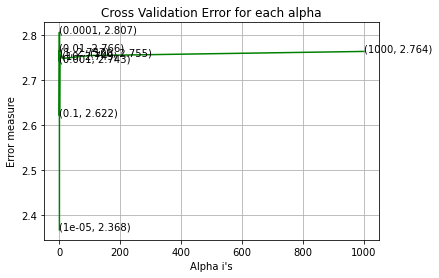

log loss for train data 1.0356231152536257
log loss for test data 2.367853387713195
Number of misclassified points  35.32351257092291
-------------------------------------------------- Confusion matrix --------------------------------------------------


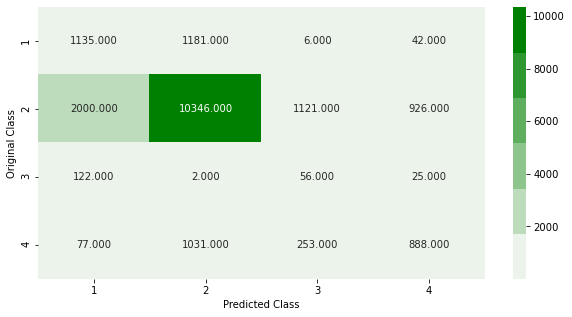

-------------------------------------------------- Precision matrix --------------------------------------------------


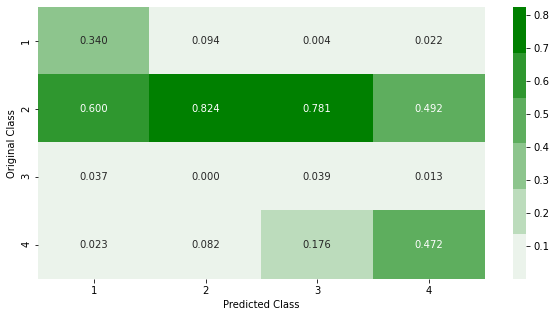

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


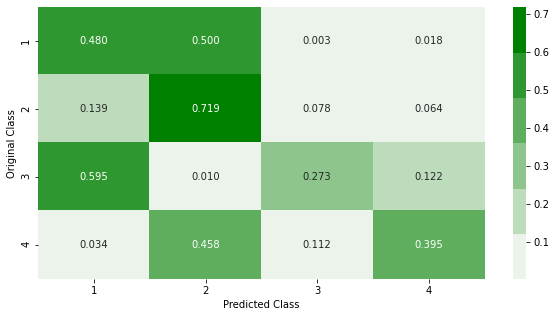

Sum of rows in precision matrix [1. 1. 1. 1.]


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")


#log loss calculation part

alpha = [10 ** x for x in range(-5, 4)]
test_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])

best_alpha = np.argmin(test_log_error_array)
    
#Cross Validation Error for each alpha

fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',(log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',(log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [36]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\LogisticRegression_multiclass_under_sampling.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\LogisticRegression_multiclass_under_sampling.joblib']

In [37]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 3


In [38]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 1


# Random Forest

log_loss for c =  10 is 1.5287901838358937
log_loss for c =  50 is 1.6124140901546318
log_loss for c =  100 is 1.6808691046652497
log_loss for c =  500 is 1.6165968037140779
log_loss for c =  1000 is 1.6202697066552627
log_loss for c =  2000 is 1.6038881103930696
log_loss for c =  3000 is 1.5989163100658481


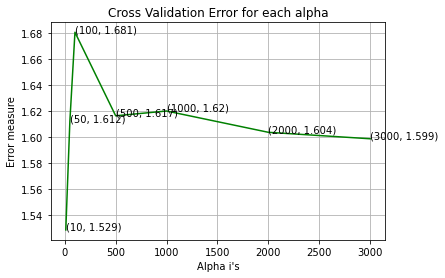

For values of best alpha =  10 The train log loss is: 0.1186057956734644
For values of best alpha =  10 The test log loss is: 1.5287901838358937
Number of misclassified points  61.40752693769195
-------------------------------------------------- Confusion matrix --------------------------------------------------


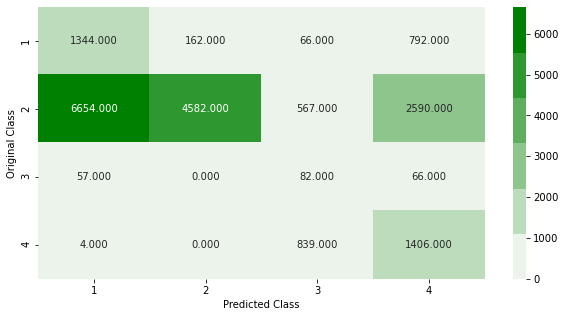

-------------------------------------------------- Precision matrix --------------------------------------------------


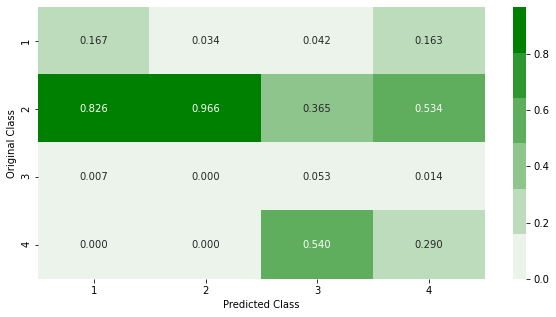

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


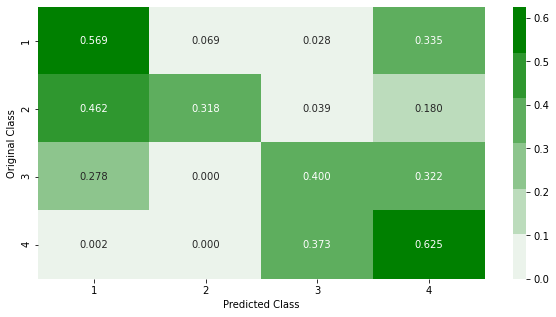

Sum of rows in precision matrix [1. 1. 1. 1.]
Number of misclassified points  61.40752693769195
-------------------------------------------------- Confusion matrix --------------------------------------------------


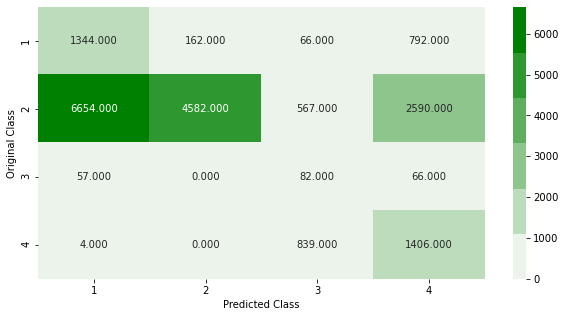

-------------------------------------------------- Precision matrix --------------------------------------------------


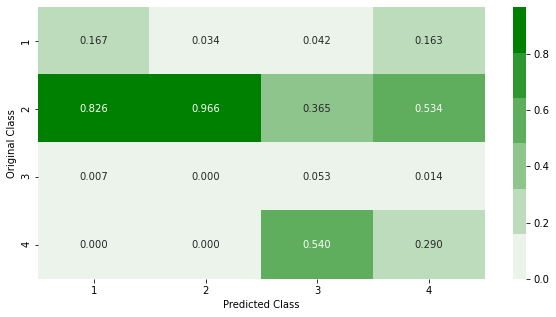

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


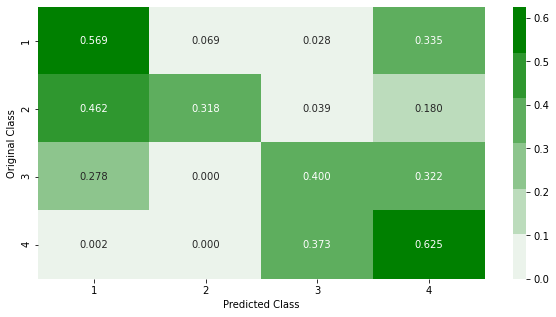

Sum of rows in precision matrix [1. 1. 1. 1.]


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")

#log loss calculation part
alpha=[10,50,100,500,1000,2000,3000]
test_log_error_array=[]

for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])


best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha

fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [40]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\RandomForestClassifier_multiclass_under_sampling.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\RandomForestClassifier_multiclass_under_sampling.joblib']

In [41]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 4


In [42]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 1


# XgBoost Classification

log_loss for c =  10 is 1.7109047413418876
log_loss for c =  50 is 1.739090504551608
log_loss for c =  100 is 1.6843077502389707
log_loss for c =  500 is 1.648132172193157
log_loss for c =  1000 is 1.6439809014312332
log_loss for c =  2000 is 1.6396129755017277


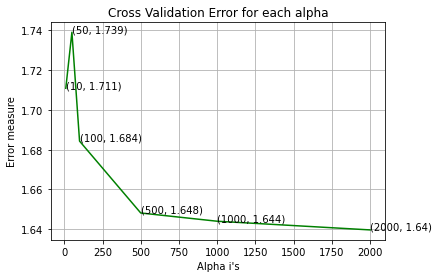

For values of best alpha =  2000 The train log loss is: 0.1616632192963454
For values of best alpha =  2000 The test log loss is: 1.6396129755017277
Number of misclassified points  62.589141637603454
-------------------------------------------------- Confusion matrix --------------------------------------------------


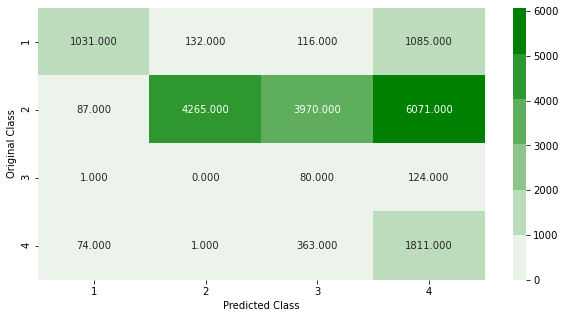

-------------------------------------------------- Precision matrix --------------------------------------------------


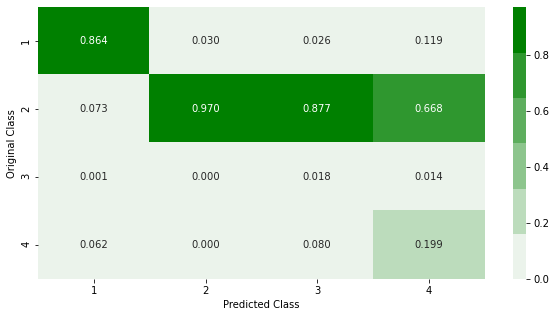

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


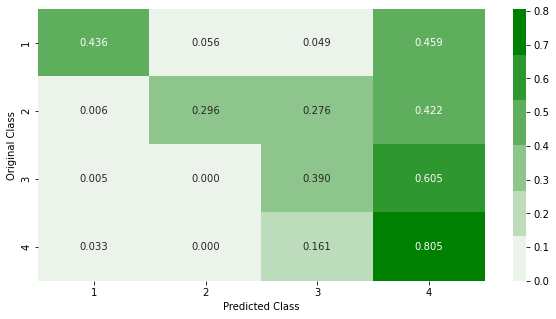

Sum of rows in precision matrix [1. 1. 1. 1.]


In [43]:
import xgboost as xgb


#log loss calculation part
alpha=[10,50,100,500,1000,2000]

test_log_error_array=[]
for i in alpha:
    x_cfl=xgb.XGBClassifier(n_estimators=i,nthread=-1,eval_metric='mlogloss')
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])


best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part

x_cfl=xgb.XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1,eval_metric='mlogloss')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [44]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\XGBClassifier_multiclass_under_sampling.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\XGBClassifier_multiclass_under_sampling.joblib']

In [45]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 4


In [46]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 1


## Part 3 Over Sampling using RandomOverSampler

In [47]:
# protocol
X_train_protocol_type , X_test_protocol_type = label_encoding(df_train,df_test,'protocol_type')

#service
X_train_service , X_test_service = label_encoding(df_train,df_test,'service')

#flag
X_train_flag , X_test_flag = label_encoding(df_train,df_test,'flag')

In [48]:
continuous_features=["duration","src_bytes",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins","num_compromised","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]



In [49]:
y = df_train['class_label_mul'] 
x = df_train[continuous_features]

In [50]:
x.shape , y.shape

((172053, 32), (172053,))

In [51]:
x['protocol_type'] = X_train_protocol_type
x['service'] = X_train_service
x['flag'] = X_train_flag


In [52]:
x.shape , y.shape

((172053, 35), (172053,))

In [53]:
from collections import Counter

Counter(y)

Counter({3: 52, 2: 159775, 4: 936, 1: 11290})

In [54]:
from imblearn.over_sampling import RandomOverSampler

os=RandomOverSampler()

X_train_ros,y_train_ros=os.fit_resample(x,y)


In [55]:
print("The number of classes before fit {}".format(Counter(y)))

print("The number of classes after fit {}".format(Counter(y_train_ros)))

The number of classes before fit Counter({2: 159775, 1: 11290, 4: 936, 3: 52})
The number of classes after fit Counter({3: 159775, 2: 159775, 4: 159775, 1: 159775})


In [56]:
X_train_ros.shape , y_train_ros.shape

((639100, 35), (639100,))

In [57]:
X_train_ros['class_label_mul'] = y_train_ros

In [58]:
X_train_ros.shape

(639100, 36)

In [59]:
X_train_ros.to_csv("over_sample_train_ros_mul.csv", index=False)


In [60]:
""" Reload the cleaned datasets """

df_train3=pd.read_csv("over_sample_train_ros_mul.csv")

In [61]:
df_train3.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,class_label_mul
0,184,1511,2957,0,0,3,0,2,0,1,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3,1.00,0.00,1.00,0.67,0.0,0.0,0.0,0.0,1,58,9,3
1,305,1735,2766,0,0,3,0,2,0,1,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,4,1.00,0.00,0.50,0.50,0.0,0.0,0.0,0.0,1,58,9,3
2,79,281,1301,0,0,2,0,1,0,4,2,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,10,1.00,0.00,1.00,0.30,0.0,0.0,0.0,0.1,1,58,9,3
3,25,269,2333,0,0,0,0,0,2,2,1,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69,2,0.03,0.06,0.01,0.00,0.0,0.0,0.0,0.0,1,58,9,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.5,1.0,0.0,0.0,0.5,1.0,0.0,1,2,1.00,0.00,1.00,1.00,1.0,0.5,0.0,0.0,1,58,5,2


In [62]:
df_train3.shape

(639100, 36)

In [63]:
y_train=df_train3['class_label_mul']

X_train=df_train3.drop(['class_label_mul'], axis = 1)

In [64]:
X_test = df_test[continuous_features]

In [65]:
X_test['protocol_type'] = X_test_protocol_type
X_test['service'] = X_test_service
X_test['flag'] = X_test_flag


In [66]:
y_test=df_test['class_label_mul']

In [67]:
X_test.shape , y_test.shape

((19211, 35), (19211,))

### Modeling

In [68]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    
    # C = 4,4 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    B =(C/C.sum(axis=0))
    
    
    labels = [1,2,3,4]
    cmap=sns.light_palette("green")
    
    #Confusion matrix
    
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #Precision matrix

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    #Recall matrix
    
    
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

# Logistic Regression 

log_loss for c =  1e-05 is 1.3847709498775307
log_loss for c =  0.0001 is 1.382566752035017
log_loss for c =  0.001 is 1.3830296933161024
log_loss for c =  0.01 is 1.3819442791144796
log_loss for c =  0.1 is 1.3819895674762694
log_loss for c =  1 is 1.3827021010583262
log_loss for c =  10 is 1.3824962816574782
log_loss for c =  100 is 1.3820410759814812
log_loss for c =  1000 is 1.382792384152066


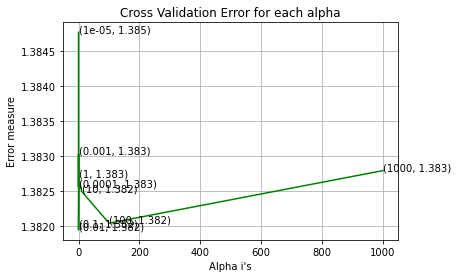

log loss for train data 1.3815976237208092
log loss for test data 1.3819442791144796
Number of misclassified points  25.07417625318828
-------------------------------------------------- Confusion matrix --------------------------------------------------


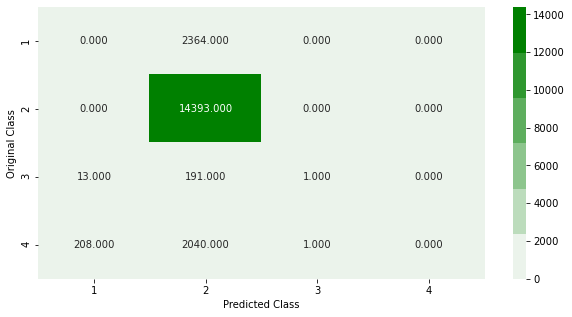

-------------------------------------------------- Precision matrix --------------------------------------------------


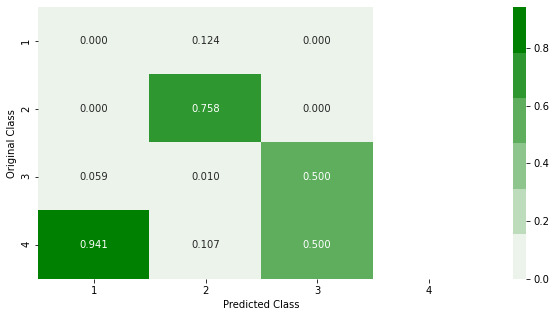

Sum of columns in precision matrix [ 1.  1.  1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


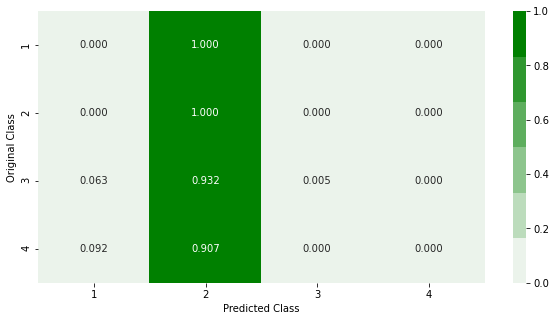

Sum of rows in precision matrix [1. 1. 1. 1.]


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")


#log loss calculation part

alpha = [10 ** x for x in range(-5, 4)]
test_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])

best_alpha = np.argmin(test_log_error_array)
 
#Cross Validation Error for each alpha

fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',(log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',(log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [70]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\LogisticRegression_multiclass_over_sampling_RandomOverSampler.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\LogisticRegression_multiclass_over_sampling_RandomOverSampler.joblib']

In [71]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 2


In [72]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 2


# Random Forest

log_loss for c =  10 is 0.6388450248950835
log_loss for c =  50 is 0.6264218584001273
log_loss for c =  100 is 0.6287342693037272
log_loss for c =  500 is 0.6721353286151852
log_loss for c =  1000 is 0.6637497059222781
log_loss for c =  2000 is 0.6533696819990358
log_loss for c =  3000 is 0.6478212950606886


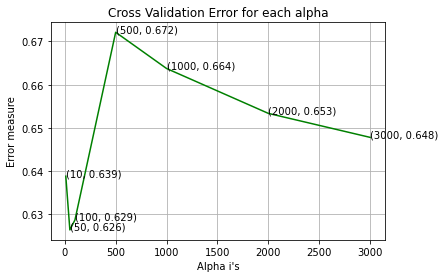

For values of best alpha =  50 The train log loss is: 0.010649890033472635
For values of best alpha =  50 The test log loss is: 0.6264218584001273
Number of misclassified points  14.736348966737806
-------------------------------------------------- Confusion matrix --------------------------------------------------


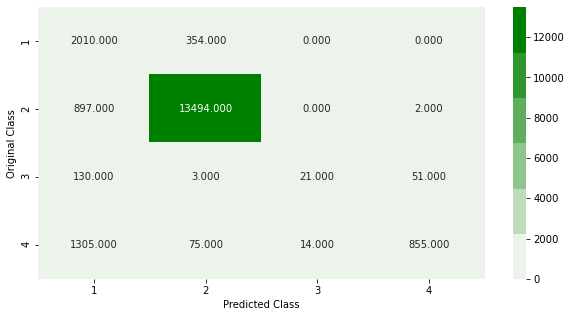

-------------------------------------------------- Precision matrix --------------------------------------------------


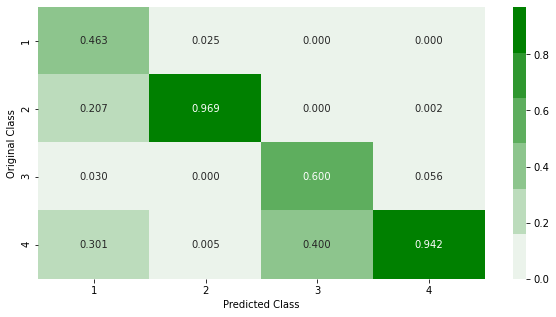

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


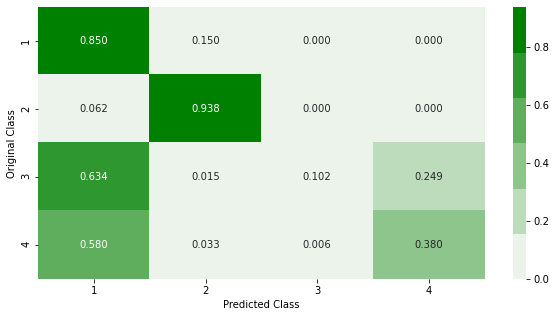

Sum of rows in precision matrix [1. 1. 1. 1.]
Number of misclassified points  14.736348966737806
-------------------------------------------------- Confusion matrix --------------------------------------------------


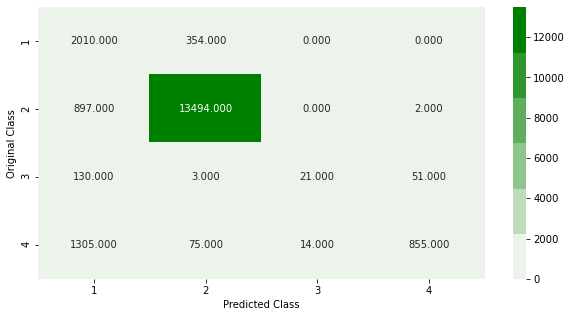

-------------------------------------------------- Precision matrix --------------------------------------------------


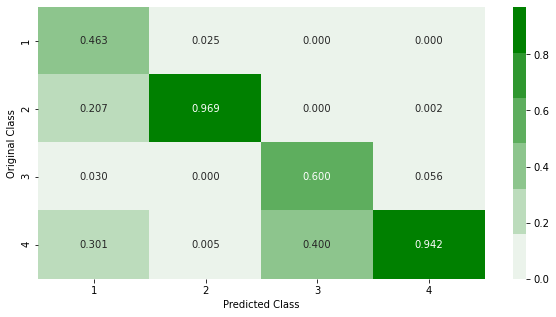

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


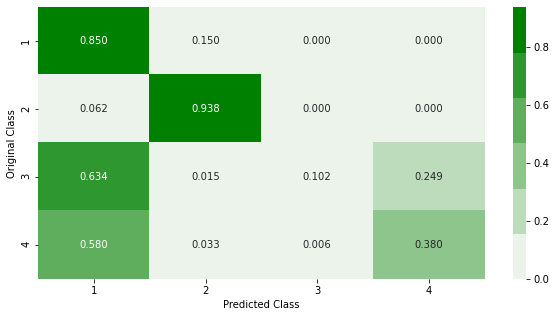

Sum of rows in precision matrix [1. 1. 1. 1.]


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")

#log loss calculation part

alpha=[10,50,100,500,1000,2000,3000]
test_log_error_array=[]

for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])


best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha

fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [74]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\RandomForestClassifier_multiclass_over_sampling_RandomOverSampler.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\RandomForestClassifier_multiclass_over_sampling_RandomOverSampler.joblib']

In [75]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 2


In [76]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 1


# XgBoost Classification

log_loss for c =  10 is 0.6145797436075597
log_loss for c =  50 is 0.7578738608766912
log_loss for c =  100 is 0.7598434913531176
log_loss for c =  500 is 0.7278979867894576
log_loss for c =  1000 is 0.7164371269314934
log_loss for c =  2000 is 0.7174018589863537


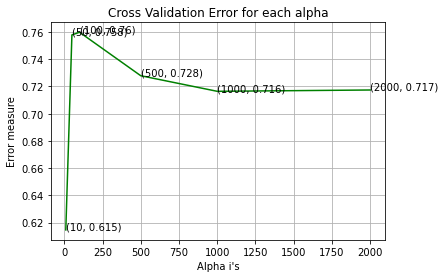

For values of best alpha =  10 The train log loss is: 0.03775674412494898
For values of best alpha =  10 The test log loss is: 0.6145797436075597
Number of misclassified points  12.347092811410128
-------------------------------------------------- Confusion matrix --------------------------------------------------


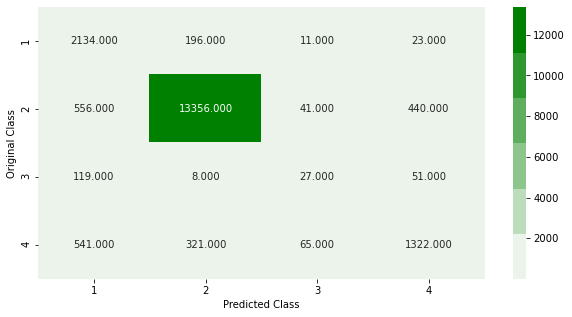

-------------------------------------------------- Precision matrix --------------------------------------------------


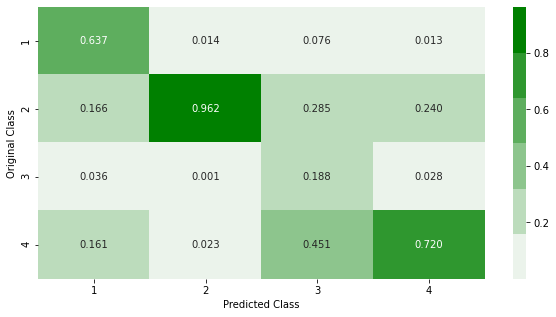

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


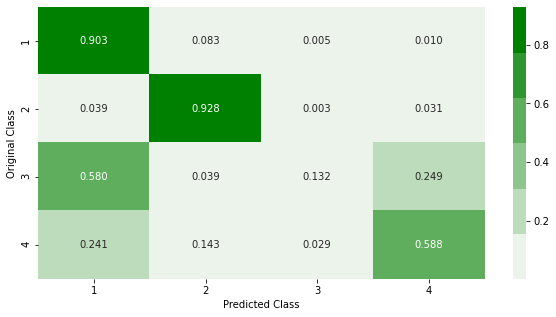

Sum of rows in precision matrix [1. 1. 1. 1.]


In [77]:
import xgboost as xgb

#log loss calculation part
alpha=[10,50,100,500,1000,2000]

test_log_error_array=[]
for i in alpha:
    x_cfl=xgb.XGBClassifier(n_estimators=i,nthread=-1,eval_metric='mlogloss')
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])


best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part
x_cfl=xgb.XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1,eval_metric='mlogloss')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [78]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\XGBClassifier_multiclass_over_sampling_RandomOverSampler.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\XGBClassifier_multiclass_over_sampling_RandomOverSampler.joblib']

In [79]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 2


In [80]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 1


## Part 4 Over Sampling using SMOTETomek

In [16]:
# protocol
X_train_protocol_type , X_test_protocol_type = label_encoding(df_train,df_test,'protocol_type')

#service
X_train_service , X_test_service = label_encoding(df_train,df_test,'service')

#flag
X_train_flag , X_test_flag = label_encoding(df_train,df_test,'flag')

In [17]:
continuous_features=["duration","src_bytes",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins","num_compromised","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]



In [83]:
y = df_train['class_label_mul'] 
x = df_train[continuous_features]

In [84]:
x.shape , y.shape

((172053, 32), (172053,))

In [85]:
x['protocol_type'] = X_train_protocol_type
x['service'] = X_train_service
x['flag'] = X_train_flag


In [86]:
x.shape , y.shape

((172053, 35), (172053,))

In [87]:
from collections import Counter

Counter(y)

Counter({3: 52, 2: 159775, 4: 936, 1: 11290})

In [88]:
from imblearn.combine import SMOTETomek

smk = SMOTETomek(random_state=42)

X_smk,y_smk=smk.fit_resample(x,y)


In [89]:
print("The number of classes before fit {}".format(Counter(y)))

print("The number of classes after fit {}".format(Counter(y_smk)))

The number of classes before fit Counter({2: 159775, 1: 11290, 4: 936, 3: 52})
The number of classes after fit Counter({2: 159770, 1: 159768, 3: 159763, 4: 159759})


In [90]:
X_smk.shape , y_smk.shape

((639060, 35), (639060,))

In [91]:
X_smk['class_label_mul'] = y_smk

In [92]:
X_smk.shape

(639060, 36)

In [93]:
X_smk.to_csv("over_sample_train_smk_mul.csv", index=False)


In [11]:
""" Reload the cleaned datasets """

df_train4=pd.read_csv("over_sample_train_smk_mul.csv")

In [12]:
df_train4.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,class_label_mul
0,184,1511,2957,0,0,3,0,2,0,1,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3,1.00,0.00,1.00,0.67,0.0,0.0,0.0,0.0,1,58,9,3
1,305,1735,2766,0,0,3,0,2,0,1,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,4,1.00,0.00,0.50,0.50,0.0,0.0,0.0,0.0,1,58,9,3
2,79,281,1301,0,0,2,0,1,0,4,2,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,10,1.00,0.00,1.00,0.30,0.0,0.0,0.0,0.1,1,58,9,3
3,25,269,2333,0,0,0,0,0,2,2,1,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69,2,0.03,0.06,0.01,0.00,0.0,0.0,0.0,0.0,1,58,9,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.5,1.0,0.0,0.0,0.5,1.0,0.0,1,2,1.00,0.00,1.00,1.00,1.0,0.5,0.0,0.0,1,58,5,2


In [13]:
df_train4.shape

(639060, 36)

In [14]:
y_train=df_train4['class_label_mul']

X_train=df_train4.drop(['class_label_mul'], axis = 1)

In [18]:
X_test = df_test[continuous_features]

In [19]:
X_test['protocol_type'] = X_test_protocol_type
X_test['service'] = X_test_service
X_test['flag'] = X_test_flag


In [20]:
y_test=df_test['class_label_mul']

In [21]:
X_test.shape , y_test.shape

((19211, 35), (19211,))

### Modeling

In [22]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    
    # C = 4,4 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    B =(C/C.sum(axis=0))
    
    
    labels = [1,2,3,4]
    cmap=sns.light_palette("green")
    
    #Confusion matrix
    
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #Precision matrix

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    #Recall matrix
    
    
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

# Logistic Regression 

log_loss for c =  1e-05 is 1.3840412589917306
log_loss for c =  0.0001 is 1.3818723012158118
log_loss for c =  0.001 is 1.3833084515605156
log_loss for c =  0.01 is 1.3802243099361224
log_loss for c =  0.1 is 1.3830304433429255
log_loss for c =  1 is 1.3830711714395079
log_loss for c =  10 is 1.3838444755153636
log_loss for c =  100 is 1.3838411471617997
log_loss for c =  1000 is 1.3832736019944067


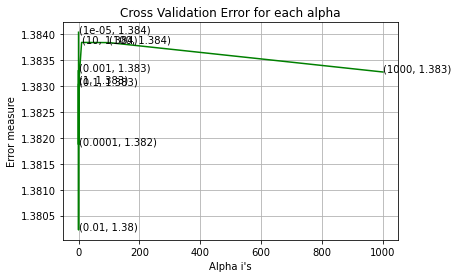

log loss for train data 1.382371765293743
log loss for test data 1.3802243099361224
Number of misclassified points  25.068970902087344
-------------------------------------------------- Confusion matrix --------------------------------------------------


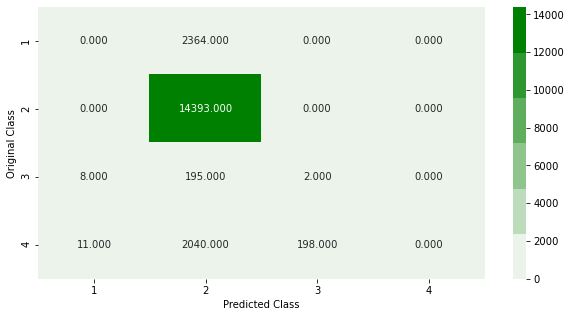

-------------------------------------------------- Precision matrix --------------------------------------------------


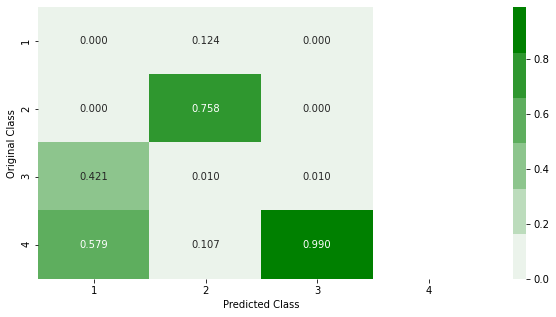

Sum of columns in precision matrix [ 1.  1.  1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


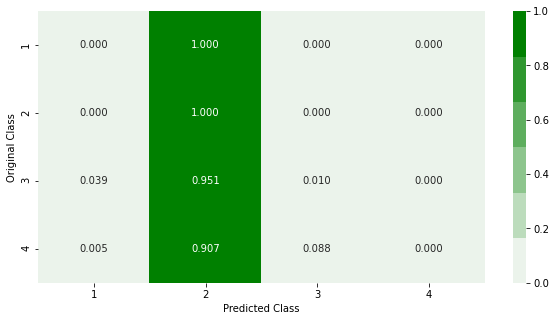

Sum of rows in precision matrix [1. 1. 1. 1.]


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")


#log loss calculation part

alpha = [10 ** x for x in range(-5, 4)]
test_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])

best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part
logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',(log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',(log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [24]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\LogisticRegression_over_sampling_SMOTETomek_mul.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\LogisticRegression_over_sampling_SMOTETomek_mul.joblib']

In [25]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 2


In [26]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 2


# Random Forest

log_loss for c =  10 is 0.4902112217638854
log_loss for c =  50 is 0.4894534086574931
log_loss for c =  100 is 0.49386110463647703
log_loss for c =  500 is 0.5103065254812567
log_loss for c =  1000 is 0.5041960832261603
log_loss for c =  2000 is 0.511849788671318
log_loss for c =  3000 is 0.5110230196328156


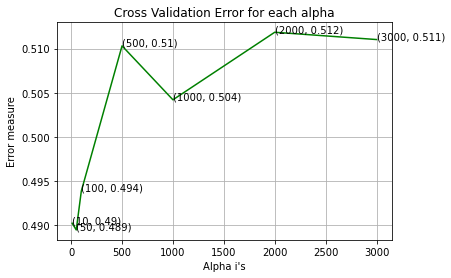

For values of best alpha =  50 The train log loss is: 0.02076761045161764
For values of best alpha =  50 The test log loss is: 0.4894534086574931
Number of misclassified points  11.769298839206705
-------------------------------------------------- Confusion matrix --------------------------------------------------


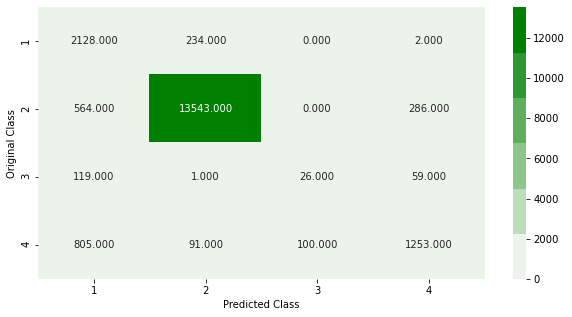

-------------------------------------------------- Precision matrix --------------------------------------------------


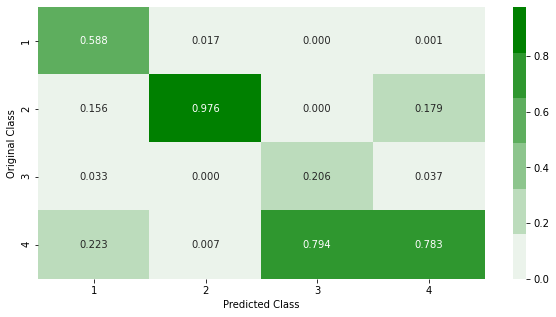

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


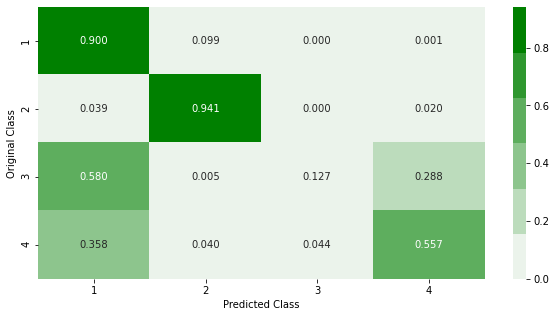

Sum of rows in precision matrix [1. 1. 1. 1.]
Number of misclassified points  11.769298839206705
-------------------------------------------------- Confusion matrix --------------------------------------------------


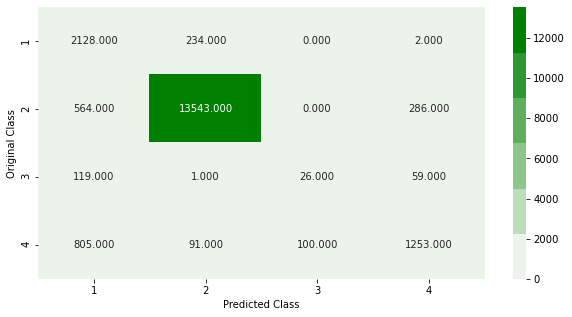

-------------------------------------------------- Precision matrix --------------------------------------------------


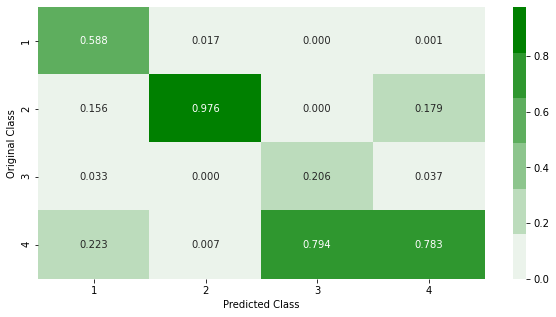

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


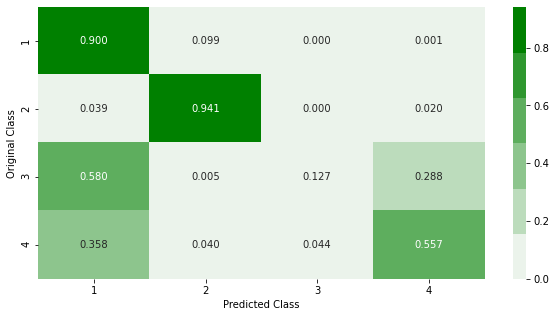

Sum of rows in precision matrix [1. 1. 1. 1.]


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")

#log loss calculation part
alpha=[10,50,100,500,1000,2000,3000]
test_log_error_array=[]

for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])


best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [28]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\RandomForestClassifier_over_sampling_SMOTETomek_mul.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\RandomForestClassifier_over_sampling_SMOTETomek_mul.joblib']

In [29]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 2


In [30]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 1


# XgBoost Classification

log_loss for c =  10 is 0.9089673547231396
log_loss for c =  50 is 0.8094222782897349
log_loss for c =  100 is 0.7568532769739286
log_loss for c =  500 is 0.7367554978613651
log_loss for c =  1000 is 0.7288500338409677
log_loss for c =  2000 is 0.7281990037688443


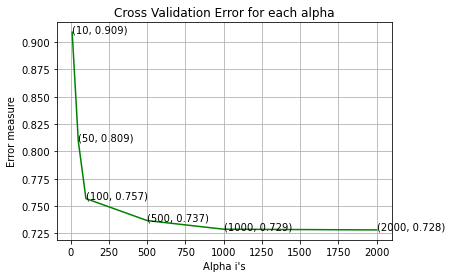

For values of best alpha =  2000 The train log loss is: 0.03614053572599618
For values of best alpha =  2000 The test log loss is: 0.7281990037688443
Number of misclassified points  10.598094841497058
-------------------------------------------------- Confusion matrix --------------------------------------------------


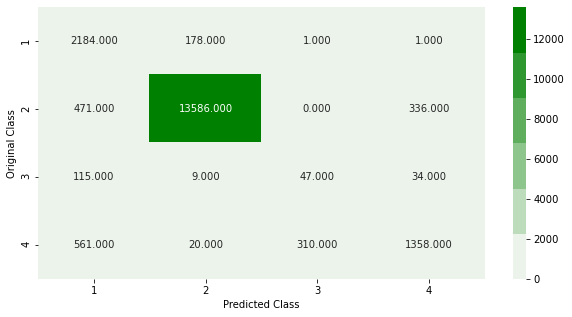

-------------------------------------------------- Precision matrix --------------------------------------------------


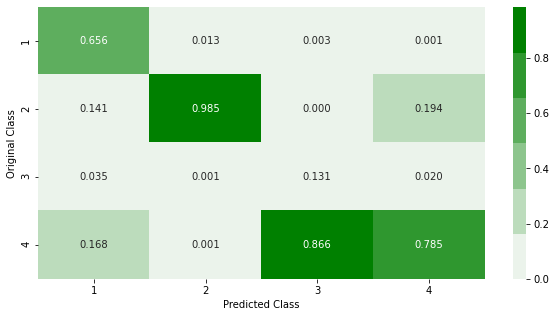

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


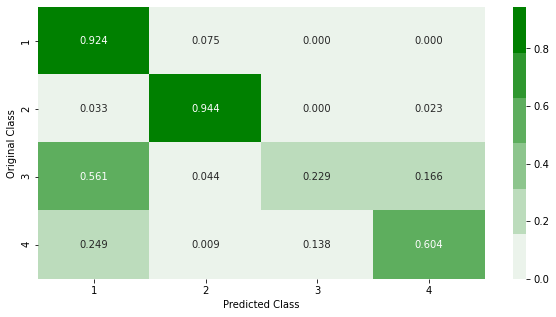

Sum of rows in precision matrix [1. 1. 1. 1.]


In [31]:
import xgboost as xgb


#log loss calculation part
alpha=[10,50,100,500,1000,2000]

test_log_error_array=[]
for i in alpha:
    x_cfl=xgb.XGBClassifier(n_estimators=i,nthread=-1,eval_metric='mlogloss')
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    test_log_error_array.append(log_loss(y_test, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(test_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',test_log_error_array[i])


best_alpha = np.argmin(test_log_error_array)

#Cross Validation Error for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, test_log_error_array,c='g')
for i, txt in enumerate(np.round(test_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

#final part
x_cfl=xgb.XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1,eval_metric='mlogloss')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [32]:
#Save model

joblib.dump(sig_clf, 'C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\XGBClassifier_over_sampling_SMOTETomek_mul.joblib')

['C:\\Users\\91912\\OneDrive\\Desktop\\cs1\\Trained_model\\XGBClassifier_over_sampling_SMOTETomek_mul.joblib']

In [33]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 567
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 2
Predicted Class : 2


In [34]:
#predict the model output

y_test_pred = sig_clf.predict(X_test)
test_point_index = 354
ac = np.array(list(df_test['class_label_mul']))

print("Actual Class :", ac[test_point_index])
print("Predicted Class :", y_test_pred[test_point_index])

Actual Class : 1
Predicted Class : 1


## Pretty Table

In [1]:
from prettytable import PrettyTable
  
table = PrettyTable(["Model", "Train Log loss", "Test Log loss", "misclassified points"])
  
#Without Over Sampling or Under Sampling

table.add_row(["Logistic Regression Without Over Sampling or Under Sampling","0.2623","0.9640","25.0793"])

table.add_row(["Random Forest  Without Over Sampling or Under Sampling","0.0162","0.4468","13.1851"])

table.add_row(["XGBOOST Without Over Sampling or Under Sampling","0.0206","0.3990","8.6721"]) #final

table.add_row(["-----","-----","------","------"])

#With Under Sampling

table.add_row(["Logistic Regression With Under Sampling","1.0356","2.3678","35.3235"])

table.add_row(["Random Forest  With Under Sampling","0.1186","1.5287","61.4075"])

table.add_row(["XGBOOST With Under Sampling","0.1616","1.6396","62.5891"])

table.add_row(["-----","-----","------","------"])

#With Over Sampling using RandomOverSampler

table.add_row(["Logistic Regression With Over Sampling using RandomOverSampler","1.3815","1.3819","25.0741"])

table.add_row(["Random Forest  With Over Sampling using RandomOverSampler","0.0106","0.6264","14.7363"])

table.add_row(["XGBOOST With Over Sampling using RandomOverSampler","0.0377","0.6145","12.3470"])

table.add_row(["-----","-----","------","------"])

#With Over Sampling using SMOTETomek

table.add_row(["Logistic Regression With Over Sampling using SMOTETomek","1.3823","1.3802","25.0689"])

table.add_row(["Random Forest  With Over Sampling using SMOTETomek","0.0207","0.4894","11.7692"])

table.add_row(["XGBOOST With Over Sampling using SMOTETomek","0.0361","0.7281","10.5980"])

print(table)  

+----------------------------------------------------------------+----------------+---------------+----------------------+
|                             Model                              | Train Log loss | Test Log loss | misclassified points |
+----------------------------------------------------------------+----------------+---------------+----------------------+
|  Logistic Regression Without Over Sampling or Under Sampling   |     0.2623     |     0.9640    |       25.0793        |
|     Random Forest  Without Over Sampling or Under Sampling     |     0.0162     |     0.4468    |       13.1851        |
|        XGBOOST Without Over Sampling or Under Sampling         |     0.0206     |     0.3990    |        8.6721        |
|                             -----                              |     -----      |     ------    |        ------        |
|            Logistic Regression With Under Sampling             |     1.0356     |     2.3678    |       35.3235        |
|               

# Conclusion

* All the models are overfitting, So we are not using any model further.

* Further, we can try with some deep learning algorithms for improvement.